# Calibration and Tracking for Image-Guided Intervention

## Introduction
Calibration of imaging equipment used during interventions is essential to enable the acquired images to be interpreted in the physical coordinates of the patient. All interventional imaging equipment must at some point  be calibrated, common examples include, Video cameras, ultrasound probes, tracked pointers, and radiographs. Less common examples include MRI and CT. In most cases calibration consists of imaging a phantom of known geometry and fitting a model of the imaging device such that the images acquired match the observed geometry.

This workshop focuses on the calibration of tracked and un-tracked video cameras, so the phantoms and physical models used are quite specific to this process. However, the methodology and data analysis techniques taught are applicable to a wider range of calibration procedures.

## Workshop
During the workshop we will calibrate a clinical laparoscope attached to both an optical tracking system (NDI Polaris Spectra) and an electromagnetic tracking system (NDI Aurora). Data collection and calibration will be performed using our own NiftyIGI and NiftyCal software. The following calibration algorithms will be used and the benefits and pitfalls of each discussed.

The aim of this work shop is 
1. Mono and stereo camera calibration using [Zhang's 2000] method.
2. Mono and stereo camera calibrations using [Tsai's 1987] method, that works with a single view of a either a coplanar or non-coplanar model.
3. Mono and stereo camera calibration using iterative refinement of control points, as in [Datta 2009]
4. Hand-eye calibration using a direct matrix multiplication method as in [Shahidi 2002]
5. Hand-eye calibration using linear least-squares as in [Tsai 1989]
6. Hand-eye calibration using non-linear minimisation as in [Malti 2013]

Each calibration method can be used with a range of feature detectors including chessboards, asymmetrical circle grids,
[AprilTags] and template matching of dots and rings.

All calibration methods use a pin hole camera model, see [OpenCV] for details.

[Zhang's 2000]: http://ieeexplore.ieee.org/document/888718/
[Tsai's 1987]: http://ieeexplore.ieee.org/document/1087109/
[Datta 2009]: http://ieeexplore.ieee.org/abstract/document/5457474/
[Shahidi 2002]: http://dx.doi.org/10.1109/TMI.2002.806597
[Tsai 1989]: http://dx.doi.org/10.1109/70.34770
[Malti 2013]: http://dx.doi.org/10.1002/rcs.1478
[AprilTags]: https://april.eecs.umich.edu/software/apriltag.html
[OpenCV]: https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html

As the calibration results become available the students will use the included Jupyter workbook [CalibrationWorkshop.ipynb] and Python library [camera_calibration.py] to analyse and compare the performance of each calibration algorithm, using a variety of validation methods. By the end of the workshop the group should be able to create a summary of the different calibration methods used and an evaluation of their performance for example ...


| Method | Tracking System | Number of Views | Residual Error | Validation Error | Pointer Error |
|--------|-----------------|-----------------|----------------|------------------|---------------|
|LSS     | Spectra         |  10             |   2 mm         |     5 mm         | 8 mm          |

etc.

## Data
The repository includes some prerecorded calibration and evaluation data to use during the workshop.



## Analysis of Calibration Results
The following code samples can be used to analyse the results of our various calibrations. We'll measure errors in pixels by comparing the position of features projected from a model using the calibration results with the feature positions extracted from a previously recorded image. 
For each calibration methods we'll analyse the results in four ways.
1. Check the camera intrinsic residual error by comparing feature positions on an image that was used for the intrinsic calibration.
2. Check the intrinsic and handeye residual error by comparing feature posititions as for 1 but with tracking data used.
3. Estimate the calibration error using an image that was not part of the calibaration data.
4. Use a tracker pointer to estimate the calibration error.

It is assumed that you have successfully installed the module software in the preceding workshop, and can run this Jupyter workbook.

Start by importing the necessary libraries. 

In [9]:
%matplotlib inline
#sksurgerycore has a nice transformation manager which makes concatenating 
#transforms much easier
import sksurgerycore as skscore
#use numpy for all our array handling
import numpy as np
# mphy0026.algorithms.camera_calibration has several helper functions.
import sys
sys.path.append("../../")
import mphy0026.algorithms.camera_calibration as cc

Next, define a helper function to output the errors in a consistent way.

In [10]:
def print_errors(deltas):
    # a few different ways of representing the error, which is best?
    print ( "Mean error = " , np.mean(deltas,axis=0), " pixels")
    print ( "Error Standard Deviation = ", np.std(deltas,axis=0), " pixels")
    absolute_errors=np.linalg.norm(deltas,axis=1);
    print ( "Mean absolute error = ", np.mean(absolute_errors), "pixels" )
    rms = np.sqrt(np.mean(np.multiply(absolute_errors,absolute_errors)))
    print ( "RMS absolute error = " , rms, " pixels.")

In the first example we calculate the pixel projection errors when no tracking data is used. The camera pose is detanermined during the calibration process. The calibration and tracking are from the same directory, so this is effectively measuring calibration residual error.

Mean error =  [ 0.00075907 -0.00040942]  pixels
Error Standard Deviation =  [0.85678868 0.86493532]  pixels
Mean absolute error =  1.0405718563165463 pixels
RMS absolute error =  1.2174566449711937  pixels.


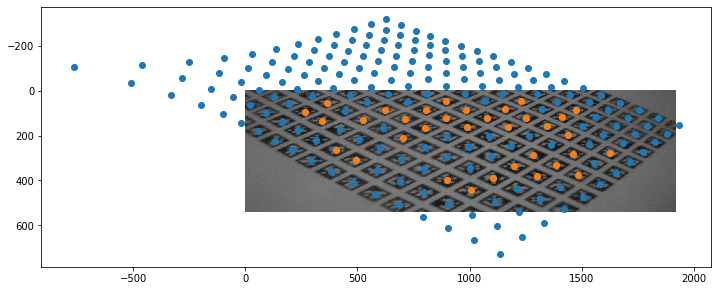

In [11]:
world_points = cc.load_model_points("CalibrationData/April216mm_centres.txt")
camera_to_world = cc.load_matrix("CalibrationData/2018.03.14_15-04-12-628/calib.left.camera.0.4x4")

world_to_camera = camera_to_world
lens_points = cc.multiply_points_by_matrix(world_points, camera_to_world)
(projection,distortion) = cc.load_intrinsic("CalibrationData/2018.03.14_15-04-12-628/calib.left.intrinsic.txt")
projected_points = cc.project(lens_points, projection)
distorted_points = cc.distort(lens_points, distortion)
projected_distorted_points=cc.project(distorted_points, projection)
screen_points=cc.load_model_points('CalibrationData/2018.03.14_15-04-12-628/calib.left.points.0.txt')

cc.plot_errors('CalibrationData/2018.03.14_15-04-12-628/calib.left.images.0.png',
               projected_distorted_points, screen_points , crop_to_image = False)

deltas = cc.calculate_errors(screen_points, projected_distorted_points )

print_errors(deltas)

The second example uses the tracking data and handeye calibration, adding tracking errors and handeye calibration errors to the calculation. It still uses the same data as was used for calibration so still measures calibration residual error.

Mean error =  [ 0.00075907 -0.00040942]  pixels
Error Standard Deviation =  [0.85678868 0.86493532]  pixels
Mean absolute error =  1.0405718563165463 pixels
RMS absolute error =  1.2174566449711937  pixels.


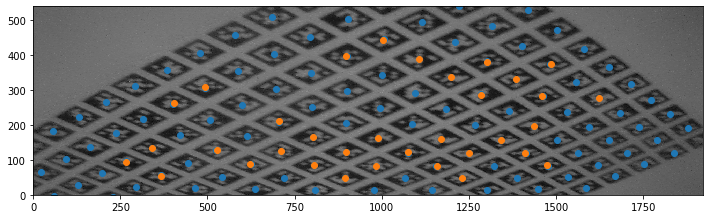

In [12]:
world_points=cc.load_model_points("CalibrationData/April216mm_centres.txt")
model_to_world=cc.load_matrix("CalibrationData/2018.03.14_15-04-12-628/calib.model2world.txt")
tracker_to_world=cc.load_matrix("CalibrationData/2018.03.14_15-04-12-628/calib.tracking.0.4x4")
camera_to_tracker=cc.load_matrix("CalibrationData/2018.03.14_15-04-12-628/calib.left.eyehand.tsai.txt")
camera_to_world=np.matmul(tracker_to_world, camera_to_tracker)
world_to_model = np.linalg.inv(model_to_world)
camera_to_model = np.matmul(world_to_model, camera_to_world)
model_to_camera = np.linalg.inv(camera_to_model)
camera_to_model_from_homog=cc.load_matrix("CalibrationData/2018.03.14_15-04-12-628/calib.left.camera.0.4x4")
lens_points = cc.multiply_points_by_matrix(world_points, (model_to_camera))
projection,distortion = cc.load_intrinsic("CalibrationData/2018.03.14_15-04-12-628/calib.left.intrinsic.txt")
projected_points= cc.project(lens_points, projection)
distorted_points = cc.distort(lens_points, distortion)
projected_distorted_doints=cc.project(distorted_points, projection)
screen_points=cc.load_model_points('CalibrationData/2018.03.14_15-04-12-628/calib.left.points.0.txt')
cc.plot_errors('CalibrationData/2018.03.14_15-04-12-628/calib.left.images.0.png',
              projected_distorted_points, screen_points, crop_to_image = True )

deltas=cc.calculate_errors(screen_points,projected_distorted_points )

print_errors(deltas)


Now we repeat the first measurement, however we use calibration and tracking data from separate directories, so this gives an actual measure of the calibration accuracy.

Mean error =  [14.56210217 -8.84807836]  pixels
Error Standard Deviation =  [4.50885651 1.8513668 ]  pixels
Mean absolute error =  17.234501730301027 pixels
RMS absolute error =  17.72288510264624  pixels.


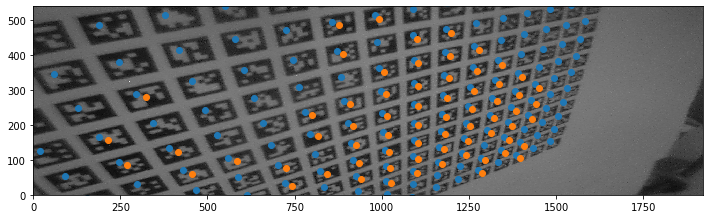

In [13]:
world_points=cc.load_model_points("CalibrationData/April216mm_centres.txt")
camera_to_world=cc.load_matrix("CalibrationData/2018.03.14_15-05-00-756/calib.left.camera.0.4x4")
lens_points = cc.multiply_points_by_matrix(world_points, (camera_to_world))
(projection,distortion) = cc.load_intrinsic("CalibrationData/2018.03.14_15-04-12-628/calib.left.intrinsic.txt")
projected_points= cc.project(lens_points, projection)
distorted_points = cc.distort(lens_points, distortion)
projected_distorted_points=cc.project(distorted_points, projection)
screen_points=cc.load_model_points('CalibrationData/2018.03.14_15-05-00-756/calib.left.points.0.txt')
cc.plot_errors('CalibrationData/2018.03.14_15-05-00-756/calib.left.images.0.png',
              projected_distorted_points, screen_points, crop_to_image = True )

deltas = cc.calculate_errors(screen_points,projected_distorted_points )

print_errors(deltas)

Now measure error using a separate pointer. This allows some assessment of the error in handeye calibration.

Mean error =  [159.51367315  13.24821427]  pixels
Error Standard Deviation =  [0. 0.]  pixels
Mean absolute error =  160.06288483888468 pixels
RMS absolute error =  160.06288483888468  pixels.


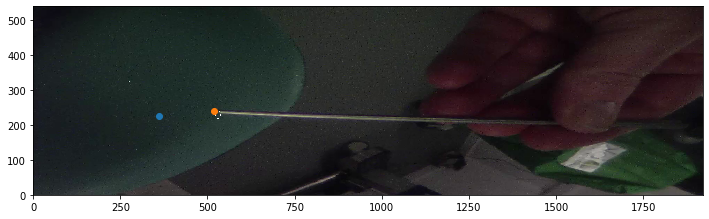

In [14]:
world_points=cc.load_model_points("CalibrationData/April216mm_centres.txt")
pointer_matrix = cc.load_matrix("CalibrationData/2018.03.14_15-01-45-586/PickedVideoPoints/1521039713875589120_pointer.txt")
pointer_tip_in_world = pointer_matrix[0:3,3]
pointer_tip_in_world = np.concatenate(([0],pointer_tip_in_world))
pointer_tip_in_world = np.reshape (pointer_tip_in_world, (1,4))
tracker_to_world=cc.load_matrix("CalibrationData/2018.03.14_15-01-45-586/PickedVideoPoints/1521039713875589120_lap.txt")
camera_to_tracker=cc.load_matrix("CalibrationData/2018.03.14_15-04-12-628/calib.left.eyehand.tsai.txt")
camera_to_world=np.matmul(tracker_to_world, camera_to_tracker)
lens_points = cc.multiply_points_by_matrix(pointer_tip_in_world, (np.linalg.inv(camera_to_world)))
projection, distortion = cc.load_intrinsic("CalibrationData/2018.03.14_15-04-12-628/calib.left.intrinsic.txt")
distorted_points = cc.distort(lens_points, distortion)
projected_distorted_points=cc.project(distorted_points, projection)
screen_points=cc.load_model_points('CalibrationData/2018.03.14_15-01-45-586/PickedVideoPoints/1521039713875589120_leftPoints.txt')
cc.plot_errors('CalibrationData/2018.03.14_15-01-45-586/PickedVideoPoints/1521039713875589120_leftPoints.png',
              projected_distorted_points, screen_points, crop_to_image = True )

deltas = cc.calculate_errors(screen_points,projected_distorted_points )
print_errors(deltas)


[Zhang's 2000]: http://ieeexplore.ieee.org/document/888718/
[Tsai's 1987]: http://ieeexplore.ieee.org/document/1087109/
[Datta 2009]: http://ieeexplore.ieee.org/abstract/document/5457474/
[Shahidi 2002]: http://dx.doi.org/10.1109/TMI.2002.806597